<a href="https://colab.research.google.com/github/ramya1807/Hospital-Playlist/blob/main/Mel_Spectrograms_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#and then to cd to any directory in the Google drive:
import os
os.chdir("drive/My Drive/CDS 2021")
#and to list all items in the directory that Colab is working on (to make sure it's the right dir):

!ls

Mounted at /content/drive
'(1) Dataset and Collection.ipynb'
'(2) Data pre-processing'
'(3) Problem and Algorithm Model'
'(4) Evaluation Methodology'
'(5) Results and Discussion'
'(All) Results of Modelling.gsheet'
'CDS Midterm Proposal.pdf'
 data_cleaned2.csv
 data_cleaned.csv
'data only'
 data_withgenre.csv
 genre.csv
'GPU setup'
 lin-reg.ipynb
 literature
 master_new.csv
 master_spotify.csv
'Meeting Notes.gdoc'
'music and mental health GitHub repo'
'Project Description.pdf'
'Proposal Presentation Script and Outline.gdoc'
'Results of Modelling (for evaluation).gsheet'
 songs_list.csv
'songs mp3'
'songs wav'
 test1.jpg
 test.jpg


In [ ]:
data = pd.read_csv('data_withgenre.csv')
data

,gender,age,amount_music,life_enjoyment,resilience,balanced_life,emotional_flex,self_actualization,trauma,total_health,health_categorical,energy,dance,liveness,valence,tempo,instrumental,acoustic,popularity,progressivetrance,anthemworship,christianmusic,popquebecois,earlymusic,talentshow,miamihiphop,basstrap,redneck,shimmerpop,ccm,electronictrap,deephouse,melodicmetalcore,canadianrock,compositionalambient,pixie,tropical,folkrock,canadianmetal,skatepunk,...,technicaldeathmetal,alternativehiphop,newromantic,southernrock,australianhiphop,melodicrap,mississippihiphop,escaperoom,upliftingtrance,undergroundhiphop,skarevival,dancehall,lilith,germanpoprock,strut,stompandholler,protopunk,boyband,shimmerpsych,hindihiphop,britishinvasion,peruvianrock,chicagorap,anti-folk,tracestep,softrock,gangsterrap,gothicmetal,cubaton,norwegianmetal,vaporsoul,alternativer&b,punkblues,chillwave,newwave,garagerock,latinpop,slowcore,britishsoul,trance
0,1,1,1,4,3,5,3,6,0,21,1.0,0.641,0.820,0.1020,0.395,117.974,0.000051,0.0662,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1,6,6,3,5,5,0,25,1.0,0.547,0.752,0.1070,0.161,111.962,0.000249,0.1130,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,6,6,3,5,5,0,25,1.0,0.655,0.526,0.1160,0.156,121.127,0.000000,0.0566,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,5,5,4,4,5,0,23,1.0,0.774,0.692,0.1410,0.771,128.033,0.000010,0.0149,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,2,3,6,5,5,5,0,24,1.0,0.516,0.631,0.2640,0.254,143.777,0.000000,0.7380,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,0,1,2,0,3,3,1,1,0,8,0.0,0.560,0.853,0.0944,0.860,134.066,0.000000,0.0130,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547,0,1,2,0,3,3,1,1,0,8,0.0,0.851,0.621,0.8870,0.449,90.940,0.000014,0.0202,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548,1,1,2,5,5,5,6,6,1,27,1.0,0.313,0.603,0.1840,0.817,99.172,0.000045,0.2480,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
549,1,1,2,5,5,5,6,6,1,27,1.0,0.442,0.574,0.1890,0.467,86.430,0.002900,0.1900,40.0,0.0,0.0,0.0,0.0,0.

In [3]:
songinfo = pd.read_csv('master_spotify.csv')
urlinfo = songinfo[songinfo['url'].notna()]
urlinfo

,Unnamed: 0,gender,age,amount_music,life_enjoyment,resilience,balanced_life,emotional_flex,self_actualization,songs,trauma,id_master,total_health,health_categorical,song_order,id_song,song,artist,energy,dance,liveness,valence,tempo,instrumental,acoustic,popularity,genres,url,spotifyid
1,1,Male,18 - 30,1 - 2,6,6,3,5,5,Put that on my set asap rocky ft skepta,No,1,25,1.0,1,1.0,Put That On My Set (feat. A$AP Rocky & Skepta),ASAP Mob,0.547,0.752,0.1070,0.161,111.962,0.000249,0.1130,52.0,"['hip hop', 'rap', 'southern hip hop', 'trap',...",https://p.scdn.co/mp3-preview/4825c7c44f7fec06...,2kwxN1whHc0YR0cBHR5iOi
2,2,Male,18 - 30,1 - 2,6,6,3,5,5,New level asap ferg,No,1,25,1.0,3,1.0,New Level,A$AP Ferg,0.655,0.526,0.1160,0.156,121.127,0.000000,0.0566,65.0,"['hip hop', 'pop', 'pop rap', 'rap', 'southern...",https://p.scdn.co/mp3-preview/5f60a5b914b04bac...,11BIoKDpTJHX5mZt6p566h
3,3,Female,18 - 30,0 - 1,5,5,4,4,5,Fireproof Coleman Hell,No,2,23,1.0,1,60.0,Fireproof,Coleman Hell,0.774,0.692,0.1410,0.771,128.033,0.000010,0.0149,47.0,"['canadian pop', 'indie poptimism', 'modern al...",https://p.scdn.co/mp3-preview/03f3548be316cae1...,34aYkYrY3sXhEU9O4VQgtB
4,4,Male,18 - 30,2+,3,6,5,5,5,Eyes Nose Lips TaeYang,No,3,24,1.0,1,3.0,"눈,코,입(Eyes, Nose, Lips)",TAEYANG,0.516,0.631,0.2640,0.254,143.777,0.000000,0.7380,67.0,"['k-pop', 'korean r&b']",https://p.scdn.co/mp3-preview/d6c6396b800df9ef...,0lYtIvI7bO51PZSeK22Mbz
5,5,Male,18 - 30,2+,3,6,5,5,5,Me Like Yuh Jay Park,No,3,24,1.0,2,3.0,Me Like Yuh,Jay Park,0.831,0.715,0.1320,0.805,100.006,0.000004,0.2230,63.0,"['k-hop', 'k-pop', 'korean pop', 'korean r&b']",https://p.scdn.co/mp3-preview/6a7d0d4a355054a7...,3SWju8HQ6II7QXkWtFSDE1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,544,Female,18 - 30,0 - 1,4,5,4,5,5,Don't Ed Sheeran,Yes,232,23,1.0,3,232.0,Don't,Ed Sheeran,0.608,0.806,0.6350,0.849,95.049,0.000000,0.0113,77.0,['pop'],https://p.scdn.co/mp3-preview/fc463b06353f9cf8...,3pXF1nA74528Edde4of9CC
546,546,Female,18 - 30,2+,0,3,3,1,1,24K Magic Bruno Mars,No,233,8,0.0,2,233.0,That's What I Like,Bruno Mars,0.560,0.853,0.0944,0.860,134.066,0.000000,0.0130,86.0,"['pop', 'post-teen pop']",https://p.scdn.co/mp3-preview/f09116ce18bd77f5...,0KKkJNfGyhkQ5aFogxQAPU
547,547,Female,18 - 30,2+,0,3,3,1,1,daddy lessons beyonce,No,233,8,0.0,3,233.0,Daddy Lessons,Beyoncé,0.851,0.621,0.8870,0.449,90.940,0.000014,0.0202,61.0,"['dance pop', 'pop', 'post-teen pop', 'r&b']",https://p.scdn.co/mp3-preview/aa63f0afae4514f6...,71OvX5NNLrmz7rpq1ANTQn
548,548,Male,18 - 30,2+,5,5,5,6,6,Crystal Blue Persuasion Tommy James,Yes,234,27,1.0,1,234.0,Crystal Blue Persuasion,Tommy James & The Shondells,0.313,0.603,0.1840,0.817,99.172,0.000045,0.2480,50.0,"['brill building pop', 'bubblegum pop', 'class...",https://p.scdn.co/mp3-preview/9d6a493d00ff689d...,6FXwTBdpv4wD0G0Sz3Wxn4


# Visualization

In [ ]:
data.columns

Index(['gender', 'age', 'amount_music', 'life_enjoyment', 'resilience',
       'balanced_life', 'emotional_flex', 'self_actualization', 'trauma',
       'total_health',
       ...
       'vaporsoul', 'alternativer&b', 'punkblues', 'chillwave', 'newwave',
       'garagerock', 'latinpop', 'slowcore', 'britishsoul', 'trance'],
      dtype='object', length=406)

# Convert mp3 to wav

In [6]:
!pip install pydub

In [7]:
from os import path
from pydub import AudioSegment
os.getcwd()
for index, row in urlinfo.iterrows():
  id = row['spotifyid']
  name = row['song']
  name = name.replace("/", "_")
  src = '/content/drive/My Drive/CDS 2021/songs mp3/{}.mp3'.format(id)
  sound = AudioSegment.from_mp3(src)
  dst = '/content/drive/My Drive/CDS 2021/songs wav/{}.wav'.format(name)
  sound.export(dst, format="wav")

# Generate Mel Spectrogram Data

#Split Spectrogram Data into Test and Val sets

In [10]:
!pip install split-folders

In [14]:
import splitfolders # or import splitfolders
input_folder = "/content/drive/My Drive/CDS 2021/spectrograms/train"
output = "/content/drive/My Drive/CDS 2021/spectrograms/output" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, 
                    output=output, 
                    seed=1337, 
                    ratio=(.7, .3), # ratio of split are in order of train/test. 
                    group_prefix=None) 

Copying files: 354 files [00:05, 70.76 files/s]


#Load Spectrogram data

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn

In [15]:
import torch
img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width)) # image size tensor
train_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/output/train' # path to train data
test_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/output/test' # path to validation data

classes = ('traumayes','traumano') # classes aka subfolders in train data

# Dataloaders

In [18]:
# Resize the image and do a center crop, and store them on a tensor
  # img_height and img_width as prev defined above
#transform = transforms.Compose([transforms.Resize(img_height),transforms.CenterCrop(img_width), transforms.ToTensor()])
augtransformation=transforms.Compose([transforms.Resize((150,150)), # size changes
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)), # rotate. translate horizontally and vertically, skew
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)), # crop size ratio
transforms.RandomHorizontalFlip(),
transforms.ToTensor()])

# Load the training and validation dataset
  # datasets.ImageFolder(filepath, transform=transformfunction)
train_dataset = datasets.ImageFolder(train_data_dir, transform=augtransformation)
test_dataset = datasets.ImageFolder(test_data_dir, transform=augtransformation)

batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2) # what does num_workers do here?
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

This is a traumano.


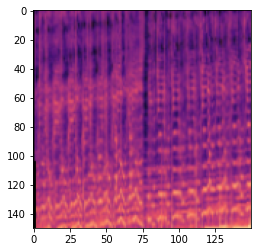

In [19]:
images,labels = next(iter(train_dataloader))
print('This is a {}.'.format(classes[labels[0]]))
plt.imshow(images[0].moveaxis(0,2))

This is a traumayes.


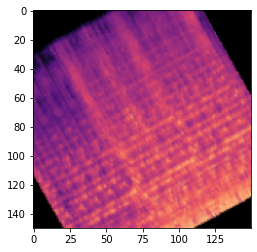

In [20]:
images,labels = next(iter(test_dataloader))
print('This is a {}.'.format(classes[labels[0]]))
plt.imshow(images[0].moveaxis(0,2))

# Build Classifier

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
import torchvision.models as models
import torch.nn as nn
model_resnet = models.resnet50(pretrained=True).to(device) #import the resnet50 model
print(model_resnet) #Let's look at the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
#we can freeze the weights by disabling gradient for the parameters, it should not be necessary in our case, since we do not plan to train the whole model, but FYI
for param in model_resnet.conv1.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False #tell the model to keep the weights fixed
for param in model_resnet.bn1.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False
for param in model_resnet.relu.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False
for param in model_resnet.maxpool.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False          
for param in model_resnet.layer1.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False
for param in model_resnet.layer2.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False
for param in model_resnet.layer3.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False
for param in model_resnet.layer4.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False
for param in model_resnet.avgpool.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False

num_features = model_resnet.fc.in_features #get the number of inputs for the layer
#features = list(model_resnet.fc.children())[:-1] # Remove last layer not required

# Newly created modules have require_grad=True by default
#features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output for binary classification
#model_resnet.fc = nn.Sequential(*features).to(device) # Replace the final classification layer
model_resnet.fc = nn.Linear(num_features,1).to(device)  # Replace the final classification layer

print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
#defining a function that will run the data through the all other non fc parts of the model
def getfeatures(model_resnet,dataloader):
  model_resnet.eval()
  output=torch.zeros((len(dataloader.dataset),2048,1,1)) # replace here
  label=torch.zeros((len(dataloader.dataset)))
  i=0

  with torch.no_grad():
    for j, data in enumerate(dataloader):
        inputs, labels = data
        inputs=inputs.to(device)
        outputs=model_resnet.avgpool(model_resnet.layer4(model_resnet.layer3(model_resnet.layer2(model_resnet.layer1(model_resnet.maxpool(model_resnet.relu(model_resnet.bn1(model_resnet.conv1(inputs)))))))))
        output[i:i+outputs.shape[0],:,:,:]=outputs
        label[i:i+labels.shape[0]]=labels
        i=i+outputs.shape[0]
        print(i)

  return output, label

In [26]:
train_feats, train_labels=getfeatures(model_resnet, train_dataloader)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

100
200
247


In [27]:
test_feats, test_labels=getfeatures(model_resnet,test_dataloader)

test_feats=test_feats.to(device)
test_labels=test_labels.to(device)

torch.save((test_feats,test_labels),'test_data.pt')

100
107


In [28]:
train_feats,train_labels=torch.load('train_data.pt')
test_feats,test_labels=torch.load('test_data.pt')

batch_size=100
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

test_feat_dataset = torch.utils.data.TensorDataset(test_feats,test_labels)
test_feat_dataloader = DataLoader(test_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

#check that it works - we should be getting two tensors - features, and labels of sizes
feata,laba=next(iter(train_feat_dataloader))
print(feata.shape)
print(laba.shape)

torch.Size([100, 2048, 1, 1])
torch.Size([100])


# Initialize and train

In [29]:
import time
def train_resnet_classifier(modelclassifier,dataloader,val_dataloader):
    modelclassifier.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        labels=labels.reshape(labels.shape[0],1).float().to(device)
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        # forward propagation
        predicted_label = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))

        # calculate loss and backpropagate to model paramters
        loss = criterion(predicted_label, labels)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelclassifier.parameters(), 0.1)
        # update parameters by stepping the optimizer
        optimizer.step()
        total_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per epoch
        rep_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per log_interval batches
        total_count += labels.size(0)
        rep_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


          # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    start_time = time.time()
    modelclassifier.eval()

    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            inputs=inputs.to(device)

            # Forward pass. (Prediction stage)
            scores = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))
            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += ((scores > 0.5) == labels).sum().item()
            val_count += labels.size(0)

    elapsed = time.time() - start_time
    # Logging the current results on validation.
    print('Test-epoch %d. Avg-Test Loss: %.4f, Test Accuracy: %.4f,   Elapsed Time: %.1f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count,elapsed))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)

In [30]:
optimizer = torch.optim.RMSprop(model_resnet.fc.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

# Evaluate on test set

In [31]:
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet_classifier(model_resnet.fc,train_feat_dataloader,test_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

Test-epoch 0. Avg-Test Loss: 0.7045, Test Accuracy: 0.5794,   Elapsed Time: 0.0
Test-epoch 1. Avg-Test Loss: 0.6630, Test Accuracy: 0.5888,   Elapsed Time: 0.0
Test-epoch 2. Avg-Test Loss: 0.7036, Test Accuracy: 0.6075,   Elapsed Time: 0.0
Test-epoch 3. Avg-Test Loss: 0.7490, Test Accuracy: 0.5888,   Elapsed Time: 0.0
Test-epoch 4. Avg-Test Loss: 0.6819, Test Accuracy: 0.5888,   Elapsed Time: 0.0
Test-epoch 5. Avg-Test Loss: 0.6573, Test Accuracy: 0.5888,   Elapsed Time: 0.0
Test-epoch 6. Avg-Test Loss: 0.7302, Test Accuracy: 0.5701,   Elapsed Time: 0.0
Test-epoch 7. Avg-Test Loss: 0.6815, Test Accuracy: 0.5794,   Elapsed Time: 0.0
Test-epoch 8. Avg-Test Loss: 0.6367, Test Accuracy: 0.5888,   Elapsed Time: 0.0
Test-epoch 9. Avg-Test Loss: 0.6368, Test Accuracy: 0.5607,   Elapsed Time: 0.0
Test-epoch 10. Avg-Test Loss: 0.6919, Test Accuracy: 0.5514,   Elapsed Time: 0.0
Test-epoch 11. Avg-Test Loss: 0.6792, Test Accuracy: 0.5514,   Elapsed Time: 0.0
Test-epoch 12. Avg-Test Loss: 0.6992, 

# Evaluate Model

In [36]:
def evaluate_resnet(model,dataloader):
    model.eval()
    normal_acc, normal_count = 0,0
    traumayes_acc, traumayes_count = 0,0
    total_acc, total_count = 0, 0
    #wrong=torch.zeros((len(dataloader.dataset)),1)
    j=0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            predicted_label = torch.sigmoid(model(inputs))
            correct=((predicted_label > 0.5) == labels)
            total_acc += correct.sum().item()
            total_count += labels.size(0)

            
            # check accuracy for each class
            for k, value in enumerate(labels):
              if(value.data[0] < 0.5):
                    normal_count += 1
                    if(correct[k].data[0] == True):
                        normal_acc += 1
              else:
                    traumayes_count += 1
                    if(correct[k].data[0] == True):
                        traumayes_acc += 1


            #wrong[j:j+labels.size(0),:]=~correct
            j=j+labels.size(0)
    return total_acc/total_count, normal_acc/normal_count, traumayes_acc/traumayes_count

In [37]:
totalaccu, normalacc, traumaacc = evaluate_resnet(model_resnet,test_dataloader)
print('Total accuracy across both classes is ', totalaccu)
print('Accuracy for trauma no images is ', normalacc)
print('Accuracy for trauma yes images is ', traumaacc)

Total accuracy across both classes is  0.514018691588785
Accuracy for trauma no images is  0.7619047619047619
Accuracy for trauma yes images is  0.1590909090909091


# Repeat for other variables

In [41]:
def evaluate_var(model,dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    wrong=torch.zeros((len(dataloader.dataset)),1)
    j=0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            predicted_label = torch.sigmoid(model(inputs))
            correct=((predicted_label > 0.5) == labels)
            total_acc += correct.sum().item()
            total_count += labels.size(0)
            wrong[j:j+labels.size(0),:]=~correct
            j=j+labels.size(0)
    return total_acc/total_count, wrong

## Life Enjoyment

In [40]:
import librosa
import librosa.display
import numpy as np
import pylab

for index, row in urlinfo.iterrows():
  songname = row['song']
  songname = songname.replace('/', '_')
  file_path = "/content/drive/My Drive/CDS 2021/songs wav/{}.wav".format(songname)
  sig, fs = librosa.load(file_path)  
  S = librosa.feature.melspectrogram(y=sig, sr=fs)
  value = row['life_enjoyment']
  if value == 0:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/0/{}.jpg'.format(songname)
  elif value == 1:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/1/{}.jpg'.format(songname)
  elif value == 2:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/2/{}.jpg'.format(songname)
  elif value == 3:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/3/{}.jpg'.format(songname)
  elif value == 4:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/4/{}.jpg'.format(songname)
  elif value == 5:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/5/{}.jpg'.format(songname)
  else:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/enjoy/6/{}.jpg'.format(songname)
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()

In [44]:
input_folder = "/content/drive/My Drive/CDS 2021/spectrograms/enjoy"
output = "/content/drive/My Drive/CDS 2021/spectrograms/enjoyoutput" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, 
                    output=output, 
                    seed=1337, 
                    ratio=(.7, .3), # ratio of split are in order of train/test. 
                    group_prefix=None) 

img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width)) # image size tensor
train_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/enjoyoutput/train' # path to train data
test_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/enjoyoutput/val' # path to validation data

classes = ('0','1', '2', '3', '4', '5', '6') # classes aka subfolders in train data

augtransformation=transforms.Compose([transforms.Resize((150,150)), # size changes
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)), # rotate. translate horizontally and vertically, skew
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)), # crop size ratio
transforms.RandomHorizontalFlip(),
transforms.ToTensor()])

# Load the training and validation dataset
  # datasets.ImageFolder(filepath, transform=transformfunction)
train_dataset = datasets.ImageFolder(train_data_dir, transform=augtransformation)
test_dataset = datasets.ImageFolder(test_data_dir, transform=augtransformation)

batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2) # what does num_workers do here?
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

train_feats, train_labels=getfeatures(model_resnet, train_dataloader)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

test_feats, test_labels=getfeatures(model_resnet,test_dataloader)

test_feats=test_feats.to(device)
test_labels=test_labels.to(device)

torch.save((test_feats,test_labels),'test_data.pt')

train_feats,train_labels=torch.load('train_data.pt')
test_feats,test_labels=torch.load('test_data.pt')

batch_size=100
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

test_feat_dataset = torch.utils.data.TensorDataset(test_feats,test_labels)
test_feat_dataloader = DataLoader(test_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

#check that it works - we should be getting two tensors - features, and labels of sizes
feata,laba=next(iter(train_feat_dataloader))
#print(feata.shape)
#print(laba.shape)

ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet_classifier(model_resnet.fc,train_feat_dataloader,test_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

accuracy, wrong = evaluate_var(model_resnet,test_dataloader)
print('Enjoyment')
print('Total accuracy is ', accuracy)

100
200
246
100
111
torch.Size([100, 2048, 1, 1])
torch.Size([100])
Test-epoch 0. Avg-Test Loss: 1.5534, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 1. Avg-Test Loss: 0.2603, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 2. Avg-Test Loss: -0.7598, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 3. Avg-Test Loss: -1.0883, Test Accuracy: 0.0541,   Elapsed Time: 0.0
Test-epoch 4. Avg-Test Loss: -1.3179, Test Accuracy: 0.0541,   Elapsed Time: 0.0
Test-epoch 5. Avg-Test Loss: -1.8588, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 6. Avg-Test Loss: -2.8438, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 7. Avg-Test Loss: -2.4761, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 8. Avg-Test Loss: -3.3081, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 9. Avg-Test Loss: -3.9133, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 10. Avg-Test Loss: -5.3334, Test Accuracy: 0.0721,   Elapsed Time: 0.0
Test-epoch 11. Avg-Test Loss: -3.8040, Tes

## Resilience

In [45]:
for index, row in urlinfo.iterrows():
  songname = row['song']
  songname = songname.replace('/', '_')
  file_path = "/content/drive/My Drive/CDS 2021/songs wav/{}.wav".format(songname)
  sig, fs = librosa.load(file_path)  
  S = librosa.feature.melspectrogram(y=sig, sr=fs)
  value = row['resilience']
  if value == 0:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/0/{}.jpg'.format(songname)
  elif value == 1:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/1/{}.jpg'.format(songname)
  elif value == 2:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/2/{}.jpg'.format(songname)
  elif value == 3:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/3/{}.jpg'.format(songname)
  elif value == 4:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/4/{}.jpg'.format(songname)
  elif value == 5:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/5/{}.jpg'.format(songname)
  else:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/resilience/6/{}.jpg'.format(songname)
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()

In [46]:
input_folder = "/content/drive/My Drive/CDS 2021/spectrograms/resilience"
output = "/content/drive/My Drive/CDS 2021/spectrograms/resilienceoutput" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, 
                    output=output, 
                    seed=1337, 
                    ratio=(.7, .3), # ratio of split are in order of train/test. 
                    group_prefix=None) 

img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width)) # image size tensor
train_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/resilienceoutput/train' # path to train data
test_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/resilienceoutput/val' # path to validation data

classes = ('0','1', '2', '3', '4', '5', '6') # classes aka subfolders in train data

augtransformation=transforms.Compose([transforms.Resize((150,150)), # size changes
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)), # rotate. translate horizontally and vertically, skew
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)), # crop size ratio
transforms.RandomHorizontalFlip(),
transforms.ToTensor()])

# Load the training and validation dataset
  # datasets.ImageFolder(filepath, transform=transformfunction)
train_dataset = datasets.ImageFolder(train_data_dir, transform=augtransformation)
test_dataset = datasets.ImageFolder(test_data_dir, transform=augtransformation)

batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2) # what does num_workers do here?
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

train_feats, train_labels=getfeatures(model_resnet, train_dataloader)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

test_feats, test_labels=getfeatures(model_resnet,test_dataloader)

test_feats=test_feats.to(device)
test_labels=test_labels.to(device)

torch.save((test_feats,test_labels),'test_data.pt')

train_feats,train_labels=torch.load('train_data.pt')
test_feats,test_labels=torch.load('test_data.pt')

batch_size=100
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

test_feat_dataset = torch.utils.data.TensorDataset(test_feats,test_labels)
test_feat_dataloader = DataLoader(test_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

#check that it works - we should be getting two tensors - features, and labels of sizes
feata,laba=next(iter(train_feat_dataloader))
#print(feata.shape)
#print(laba.shape)

ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet_classifier(model_resnet.fc,train_feat_dataloader,test_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

accuracy, wrong = evaluate_var(model_resnet,test_dataloader)
print('Resilience')
print('Total accuracy is ', accuracy)

Copying files: 357 files [00:05, 68.82 files/s]


100
200
247
100
110
Test-epoch 0. Avg-Test Loss: -223.2432, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 1. Avg-Test Loss: -261.3790, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 2. Avg-Test Loss: -260.2029, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 3. Avg-Test Loss: -250.0111, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 4. Avg-Test Loss: -263.0722, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 5. Avg-Test Loss: -264.4845, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 6. Avg-Test Loss: -222.3509, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 7. Avg-Test Loss: -224.4297, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 8. Avg-Test Loss: -282.9951, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 9. Avg-Test Loss: -295.8666, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 10. Avg-Test Loss: -297.9743, Test Accuracy: 0.0273,   Elapsed Time: 0.0
Test-epoch 11. Avg-Test Loss: -272.6818, Test Accuracy: 0.0273,   

## Balance

In [47]:
for index, row in urlinfo.iterrows():
  songname = row['song']
  songname = songname.replace('/', '_')
  file_path = "/content/drive/My Drive/CDS 2021/songs wav/{}.wav".format(songname)
  sig, fs = librosa.load(file_path)  
  S = librosa.feature.melspectrogram(y=sig, sr=fs)
  value = row['balanced_life']
  if value == 0:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/0/{}.jpg'.format(songname)
  elif value == 1:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/1/{}.jpg'.format(songname)
  elif value == 2:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/2/{}.jpg'.format(songname)
  elif value == 3:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/3/{}.jpg'.format(songname)
  elif value == 4:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/4/{}.jpg'.format(songname)
  elif value == 5:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/5/{}.jpg'.format(songname)
  else:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/balance/6/{}.jpg'.format(songname)
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()

In [48]:
input_folder = "/content/drive/My Drive/CDS 2021/spectrograms/balance"
output = "/content/drive/My Drive/CDS 2021/spectrograms/balanceoutput" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, 
                    output=output, 
                    seed=1337, 
                    ratio=(.7, .3), # ratio of split are in order of train/test. 
                    group_prefix=None) 

img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width)) # image size tensor
train_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/balanceoutput/train' # path to train data
test_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/balanceoutput/val' # path to validation data

classes = ('0','1', '2', '3', '4', '5', '6') # classes aka subfolders in train data

augtransformation=transforms.Compose([transforms.Resize((150,150)), # size changes
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)), # rotate. translate horizontally and vertically, skew
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)), # crop size ratio
transforms.RandomHorizontalFlip(),
transforms.ToTensor()])

# Load the training and validation dataset
  # datasets.ImageFolder(filepath, transform=transformfunction)
train_dataset = datasets.ImageFolder(train_data_dir, transform=augtransformation)
test_dataset = datasets.ImageFolder(test_data_dir, transform=augtransformation)

batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2) # what does num_workers do here?
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

train_feats, train_labels=getfeatures(model_resnet, train_dataloader)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

test_feats, test_labels=getfeatures(model_resnet,test_dataloader)

test_feats=test_feats.to(device)
test_labels=test_labels.to(device)

torch.save((test_feats,test_labels),'test_data.pt')

train_feats,train_labels=torch.load('train_data.pt')
test_feats,test_labels=torch.load('test_data.pt')

batch_size=100
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

test_feat_dataset = torch.utils.data.TensorDataset(test_feats,test_labels)
test_feat_dataloader = DataLoader(test_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

#check that it works - we should be getting two tensors - features, and labels of sizes
feata,laba=next(iter(train_feat_dataloader))
#print(feata.shape)
#print(laba.shape)

ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet_classifier(model_resnet.fc,train_feat_dataloader,test_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

accuracy, wrong = evaluate_var(model_resnet,test_dataloader)
print('Balanced Life')
print('Total accuracy is ', accuracy)

Copying files: 357 files [00:05, 70.88 files/s]


100
200
247
100
110
Test-epoch 0. Avg-Test Loss: -271.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 1. Avg-Test Loss: -303.0000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 2. Avg-Test Loss: -271.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 3. Avg-Test Loss: -235.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 4. Avg-Test Loss: -204.0000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 5. Avg-Test Loss: -253.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 6. Avg-Test Loss: -271.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 7. Avg-Test Loss: -280.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 8. Avg-Test Loss: -298.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 9. Avg-Test Loss: -280.5000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 10. Avg-Test Loss: -231.0000, Test Accuracy: 0.0455,   Elapsed Time: 0.0
Test-epoch 11. Avg-Test Loss: -289.5000, Test Accuracy: 0.0455,   

## Emotional flexibility

In [49]:
for index, row in urlinfo.iterrows():
  songname = row['song']
  songname = songname.replace('/', '_')
  file_path = "/content/drive/My Drive/CDS 2021/songs wav/{}.wav".format(songname)
  sig, fs = librosa.load(file_path)  
  S = librosa.feature.melspectrogram(y=sig, sr=fs)
  value = row['emotional_flex']
  if value == 0:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/0/{}.jpg'.format(songname)
  elif value == 1:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/1/{}.jpg'.format(songname)
  elif value == 2:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/2/{}.jpg'.format(songname)
  elif value == 3:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/3/{}.jpg'.format(songname)
  elif value == 4:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/4/{}.jpg'.format(songname)
  elif value == 5:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/5/{}.jpg'.format(songname)
  else:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex/6/{}.jpg'.format(songname)
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()

In [50]:
input_folder = "/content/drive/My Drive/CDS 2021/spectrograms/emotionalflex"
output = "/content/drive/My Drive/CDS 2021/spectrograms/emotionalflexoutput" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, 
                    output=output, 
                    seed=1337, 
                    ratio=(.7, .3), # ratio of split are in order of train/test. 
                    group_prefix=None) 

img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width)) # image size tensor
train_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflexoutput/train' # path to train data
test_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/emotionalflexoutput/val' # path to validation data

classes = ('0','1', '2', '3', '4', '5', '6') # classes aka subfolders in train data

augtransformation=transforms.Compose([transforms.Resize((150,150)), # size changes
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)), # rotate. translate horizontally and vertically, skew
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)), # crop size ratio
transforms.RandomHorizontalFlip(),
transforms.ToTensor()])

# Load the training and validation dataset
  # datasets.ImageFolder(filepath, transform=transformfunction)
train_dataset = datasets.ImageFolder(train_data_dir, transform=augtransformation)
test_dataset = datasets.ImageFolder(test_data_dir, transform=augtransformation)

batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2) # what does num_workers do here?
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

train_feats, train_labels=getfeatures(model_resnet, train_dataloader)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

test_feats, test_labels=getfeatures(model_resnet,test_dataloader)

test_feats=test_feats.to(device)
test_labels=test_labels.to(device)

torch.save((test_feats,test_labels),'test_data.pt')

train_feats,train_labels=torch.load('train_data.pt')
test_feats,test_labels=torch.load('test_data.pt')

batch_size=100
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

test_feat_dataset = torch.utils.data.TensorDataset(test_feats,test_labels)
test_feat_dataloader = DataLoader(test_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

#check that it works - we should be getting two tensors - features, and labels of sizes
feata,laba=next(iter(train_feat_dataloader))
#print(feata.shape)
#print(laba.shape)

ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet_classifier(model_resnet.fc,train_feat_dataloader,test_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

accuracy, wrong = evaluate_var(model_resnet,test_dataloader)
print('Emotional flexibility')
print('Total accuracy is ', accuracy)

Copying files: 357 files [00:05, 69.16 files/s]


100
200
246
100
111
Test-epoch 0. Avg-Test Loss: -251.6713, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 1. Avg-Test Loss: -271.8986, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 2. Avg-Test Loss: -257.8182, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 3. Avg-Test Loss: -261.8636, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 4. Avg-Test Loss: -241.6364, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 5. Avg-Test Loss: -269.9545, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 6. Avg-Test Loss: -225.4545, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 7. Avg-Test Loss: -253.7727, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 8. Avg-Test Loss: -298.2727, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 9. Avg-Test Loss: -253.7727, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 10. Avg-Test Loss: -221.4091, Test Accuracy: 0.0631,   Elapsed Time: 0.0
Test-epoch 11. Avg-Test Loss: -278.0455, Test Accuracy: 0.0631,   

## Self Actualization

In [52]:
for index, row in urlinfo.iterrows():
  songname = row['song']
  songname = songname.replace('/', '_')
  file_path = "/content/drive/My Drive/CDS 2021/songs wav/{}.wav".format(songname)
  sig, fs = librosa.load(file_path)  
  S = librosa.feature.melspectrogram(y=sig, sr=fs)
  value = row['self_actualization']
  if value == 0:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/0/{}.jpg'.format(songname)
  elif value == 1:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/1/{}.jpg'.format(songname)
  elif value == 2:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/2/{}.jpg'.format(songname)
  elif value == 3:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/3/{}.jpg'.format(songname)
  elif value == 4:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/4/{}.jpg'.format(songname)
  elif value == 5:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/5/{}.jpg'.format(songname)
  else:
    save_path = '/content/drive/My Drive/CDS 2021/spectrograms/selfact/6/{}.jpg'.format(songname)
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()

In [53]:
input_folder = "/content/drive/My Drive/CDS 2021/spectrograms/selfact"
output = "/content/drive/My Drive/CDS 2021/spectrograms/selfactoutput" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, 
                    output=output, 
                    seed=1337, 
                    ratio=(.7, .3), # ratio of split are in order of train/test. 
                    group_prefix=None) 

img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width)) # image size tensor
train_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/selfactoutput/train' # path to train data
test_data_dir = '/content/drive/My Drive/CDS 2021/spectrograms/selfactoutput/val' # path to validation data

classes = ('0','1', '2', '3', '4', '5', '6') # classes aka subfolders in train data

augtransformation=transforms.Compose([transforms.Resize((150,150)), # size changes
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)), # rotate. translate horizontally and vertically, skew
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)), # crop size ratio
transforms.RandomHorizontalFlip(),
transforms.ToTensor()])

# Load the training and validation dataset
  # datasets.ImageFolder(filepath, transform=transformfunction)
train_dataset = datasets.ImageFolder(train_data_dir, transform=augtransformation)
test_dataset = datasets.ImageFolder(test_data_dir, transform=augtransformation)

batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2) # what does num_workers do here?
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

train_feats, train_labels=getfeatures(model_resnet, train_dataloader)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

test_feats, test_labels=getfeatures(model_resnet,test_dataloader)

test_feats=test_feats.to(device)
test_labels=test_labels.to(device)

torch.save((test_feats,test_labels),'test_data.pt')

train_feats,train_labels=torch.load('train_data.pt')
test_feats,test_labels=torch.load('test_data.pt')

batch_size=100
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

test_feat_dataset = torch.utils.data.TensorDataset(test_feats,test_labels)
test_feat_dataloader = DataLoader(test_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

#check that it works - we should be getting two tensors - features, and labels of sizes
feata,laba=next(iter(train_feat_dataloader))
#print(feata.shape)
#print(laba.shape)

ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet_classifier(model_resnet.fc,train_feat_dataloader,test_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

accuracy, wrong = evaluate_var(model_resnet,test_dataloader)
print('Self-actualization')
print('Total accuracy is ', accuracy)

Copying files: 357 files [00:05, 69.39 files/s]


100
200
247
100
110
Test-epoch 0. Avg-Test Loss: -299.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 1. Avg-Test Loss: -326.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 2. Avg-Test Loss: -331.0000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 3. Avg-Test Loss: -317.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 4. Avg-Test Loss: -317.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 5. Avg-Test Loss: -349.0000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 6. Avg-Test Loss: -299.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 7. Avg-Test Loss: -349.0000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 8. Avg-Test Loss: -322.0000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 9. Avg-Test Loss: -344.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 10. Avg-Test Loss: -299.5000, Test Accuracy: 0.0364,   Elapsed Time: 0.0
Test-epoch 11. Avg-Test Loss: -299.5000, Test Accuracy: 0.0364,   